In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

path = r"C:\Users\narea\Desktop\Dataset"
def findFiles(path): return glob.glob(path)
#데이터 불러오기

In [3]:
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

import cv2
import numpy as np
from matplotlib import pyplot as plt

image_list1 = [os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith('.png')]
image_list2 = [os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith('.jpg')]

image_list = image_list1+image_list2
transform = transforms.ToTensor()

dataset = []
labels = []

for idx in image_list:
    image = cv2.imread(idx, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (150,150))
    image = Image.fromarray(image)
    image = transform(image)
    dataset.append(image)

    filename = os.path.basename(idx).lower()
    if 'o' in filename:
        labels.append(0) #결과 레이블 'o'
    elif 'x' in filename:
        labels.append(1) #결과 레이블 'x'

print(f"dataset 배열 크기 : {len(dataset)}")
print(f"첫번째 원소값 사이즈: {dataset[0].size()}")

dataset 배열 크기 : 280
첫번째 원소값 사이즈: torch.Size([1, 150, 150])


In [4]:
vertical_filter = np.array([[1, 0, -1],
                            [1, 0, -1],
                            [1, 0, -1]])

horizontal_filter = np.array([[1, 1, 1],
                              [0, 0, 0],
                              [-1, -1, -1]])

In [5]:
def apply_filter(image, filter):
    image = np.array(image)
    image_height, image_width = image.shape #이미지의 크기
    filter_height, filter_width = filter.shape #이미지의 필터

    # 코드
    stride = 1
    h_size = int(1+(image_height-filter_height)/stride)
    w_size = int(1+(image_width-filter_width)/stride)
    FeatureMap = np.zeros((h_size, w_size)) #사이즈 맞춰서 맵 만들어주기

    for i in range(h_size):
        for j in range(w_size):
            FeatureMap[i][j] = np.sum(image[i:i+3,j:j+3] * filter)
    
    output_image = FeatureMap

    return output_image

vertical_output = apply_filter(image[0], vertical_filter)

horizontal_output = apply_filter(image[0], horizontal_filter)

combined_output = vertical_output + horizontal_output



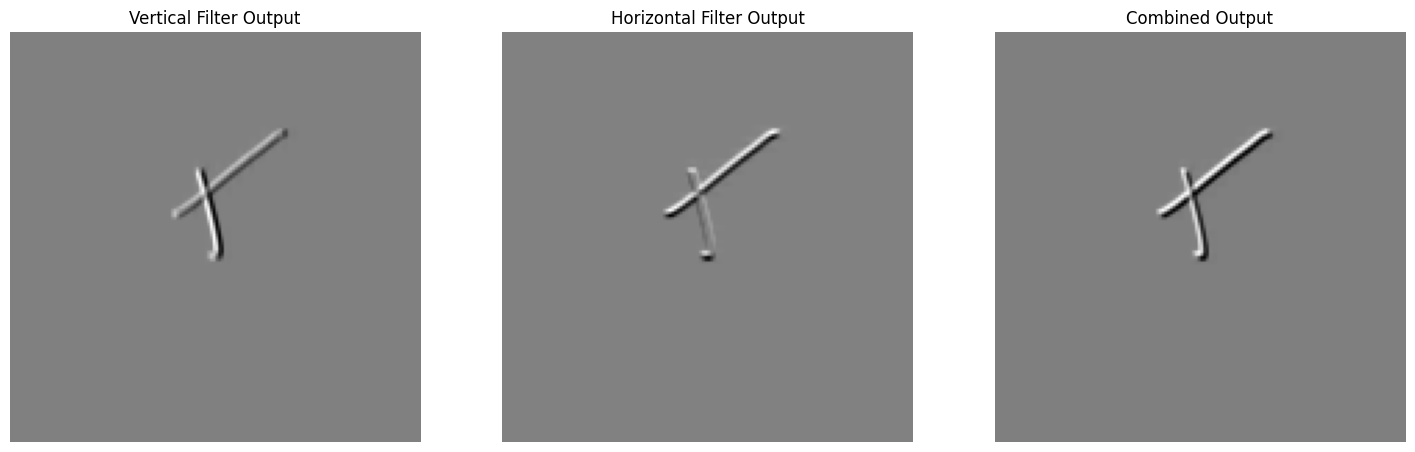

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].imshow(vertical_output, cmap='gray')
ax[0].set_title('Vertical Filter Output')
ax[0].axis('off')
ax[1].imshow(horizontal_output, cmap='gray')
ax[1].set_title('Horizontal Filter Output')
ax[1].axis('off')
ax[2].imshow(combined_output, cmap='gray')
ax[2].set_title('Combined Output')
ax[2].axis('off')
plt.show()

In [7]:
def apply_filter_stride(image, filter, stride=2):
    image_height, image_width = image.shape
    filter_height, filter_width = filter.shape
    
    output_height = (image_height - filter_height) // stride + 1
    output_width = (image_width - filter_width) // stride + 1
    
    output_image = np.zeros((output_height, output_width))
    
    for i in range(0, image_height - filter_height + 1, stride):
        for j in range(0, image_width - filter_width + 1, stride):
            output_image[i // stride, j // stride] = np.sum(image[i:i+filter_height, j:j+filter_width] * filter)
    
    return output_image

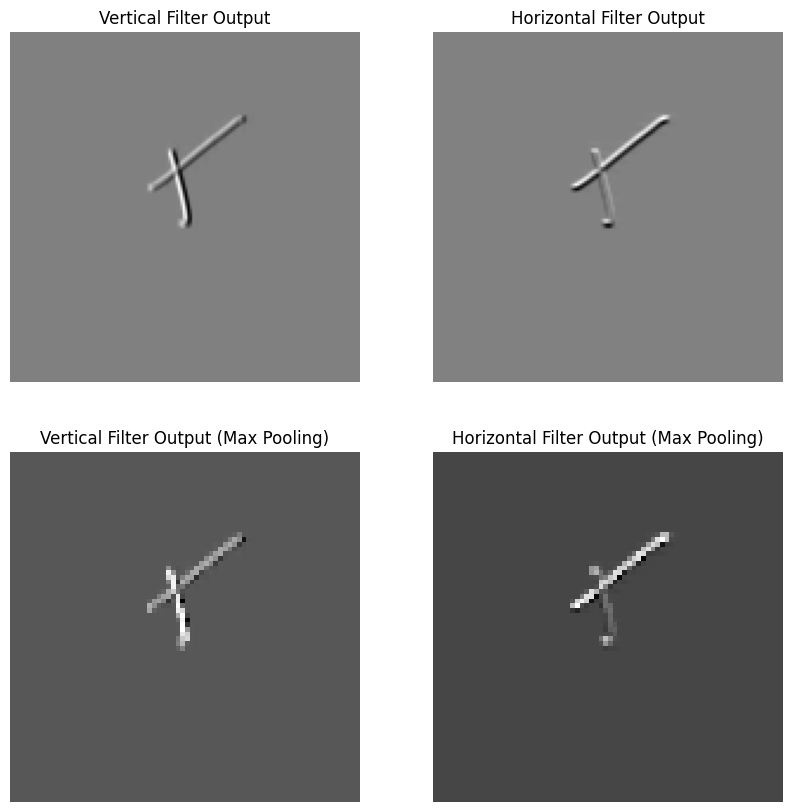

In [8]:
def max_pooling(image, pool_size):
    
    image_height, image_width = image.shape
    pool_height, pool_width = pool_size

    output_height = image_height // pool_height
    output_width = image_width // pool_width
    output_image = np.zeros((output_height, output_width))

    for i in range(0, output_height * pool_height, pool_height):
        for j in range(0, output_width * pool_width, pool_width):
            output_image[i // pool_height, j // pool_width] = np.max(image[i:i+pool_height, j:j+pool_width])
    
    return output_image

vertical_output_pool = max_pooling(vertical_output, (2, 2))
horizontal_output_pool = max_pooling(horizontal_output, (2, 2))

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(vertical_output, cmap='gray')
ax[0, 0].set_title('Vertical Filter Output')
ax[0, 0].axis('off')
ax[0, 1].imshow(horizontal_output, cmap='gray')
ax[0, 1].set_title('Horizontal Filter Output')
ax[0, 1].axis('off')
ax[1, 0].imshow(vertical_output_pool, cmap='gray')
ax[1, 0].set_title('Vertical Filter Output (Max Pooling)')
ax[1, 0].axis('off')
ax[1, 1].imshow(horizontal_output_pool, cmap='gray')
ax[1, 1].set_title('Horizontal Filter Output (Max Pooling)')
ax[1, 1].axis('off')
plt.show()

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.datasets as dsets
import torchvision.transforms as transforms

from torch.utils.data import DataLoader

In [10]:
num_epochs = 5
batch_size = 64
learning_rate = 0.001

In [11]:
# 리스트를 텐서로 변환
labels = torch.tensor(labels, dtype=torch.long)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(list(zip(dataset, labels)), [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, padding=2),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.MaxPool2d(2))  # 1x150x150 -> 4x76x76

        self.conv2 = nn.Sequential(
            nn.Conv2d(4, 36, kernel_size=3, padding=2),
            nn.BatchNorm2d(36),
            nn.ReLU(),
            nn.MaxPool2d(2))  # 4x76x76 -> 36x39x39

        self.fc = nn.Linear(36 * 39 * 39, 2)  # 36x39x39 -> 2

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [13]:
model = CNN()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [14]:
for epoch in range(num_epochs):
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()
        
        running_loss += loss.item()

In [15]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Result: {100 * correct / total}%')

Result: 78.57142857142857%


In [16]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1),  # 1x150x150 -> 4x150x150
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.MaxPool2d(2))  # 4x150x150 -> 4x75x75

        self.conv2 = nn.Sequential(
            nn.Conv2d(4, 36, kernel_size=3, stride=1, padding=1),  # 4x75x75 -> 36x75x75
            nn.BatchNorm2d(36),
            nn.ReLU(),
            nn.MaxPool2d(2))  # 36x75x75 -> 36x37x37

        self.fc = nn.Linear(36 * 37 * 37, 2)  # 36x37x37 -> 2

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
model = CNN()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()
        
        running_loss += loss.item()

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Result: {100 * correct / total}%')

Result: 82.14285714285714%
